In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import ChainMap
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
%matplotlib inline

C:\Users\binmh\AppData\Local\Temp\ipykernel_27092\3040558485.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data = pd.read_csv('ST87253_kc_house_data_.csv')

In [3]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,1800,7503


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  int64  
 9   view           21597 non-null  int64  
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  int64  
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   21597 non-null  int64  
 16  sqft_living15  21597 non-null  int64  
 17  sqft_lot15     21597 non-null  int64  
dtypes: flo

In [5]:
data.drop(['id'], axis = 1, inplace = True)

In [6]:
data['date'] = pd.to_datetime(data['date'])

In [7]:
data['sales_year'] = data['date'].dt.year
sales_year = data.pop('sales_year')
data.insert(1, 'sales_year', sales_year)

In [8]:
data['age_of_house'] = data['sales_year'] - data['yr_built']

In [9]:
data['years_since_renovation'] = data.apply(
    lambda row: row['date'].year - row['yr_renovated'] if row['yr_renovated'] > 0 else 0, axis=1
)

In [10]:
data.drop(['yr_built','yr_renovated', 'date'],axis=1, inplace=True)

In [11]:
data['total_sqft'] = data['sqft_above'] + data['sqft_basement']

In [12]:
data['waterfront'] = data['waterfront'].astype('object')
data['condition'] = data['condition'].astype('object')
data['view'] = data['view'].astype('object')

In [13]:
data['view'].value_counts()

view
0    19475
2      961
3      510
1      332
4      319
Name: count, dtype: int64

In [14]:
data['condition'].value_counts()

condition
3    14020
4     5677
5     1701
2      170
1       29
Name: count, dtype: int64

In [15]:
cat = ['view', 'condition', 'waterfront']

In [16]:
data_cat = data[cat]

In [17]:
data_num = data.select_dtypes(include=['int64','float64'])

# Exploratory Data Analysis

## Descriptive Statistics

In [18]:
data_num.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
price,21597.0,540296.57,367368.14,78000.0,322000.00,450000.00,645000.0,7700000.0
bedrooms,21597.0,3.37,0.93,1.0,3.00,3.00,4.0,33.0
bathrooms,21597.0,2.12,0.77,0.5,1.75,2.25,2.5,8.0
sqft_living,21597.0,2080.32,918.11,370.0,1430.00,1910.00,2550.0,13540.0
sqft_lot,21597.0,15099.41,41412.64,520.0,5040.00,7618.00,10685.0,1651359.0
floors,21597.0,1.49,0.54,1.0,1.00,1.50,2.0,3.5
grade,21597.0,7.66,1.17,3.0,7.00,7.00,8.0,13.0
sqft_above,21597.0,1788.60,827.76,370.0,1190.00,1560.00,2210.0,9410.0
sqft_basement,21597.0,291.73,442.67,0.0,0.00,0.00,560.0,4820.0
sqft_living15,21597.0,1986.62,685.23,399.0,1490.00,1840.00,2360.0,6210.0


In [19]:
# quantile 0.9
Q90 = data_num.quantile(0.9)
Q90.T

price                     887000.0
bedrooms                       4.0
bathrooms                      3.0
sqft_living                 3254.0
sqft_lot                   21371.6
floors                         2.0
grade                          9.0
sqft_above                  2950.0
sqft_basement                970.0
sqft_living15               2930.0
sqft_lot15                 17822.0
age_of_house                  89.0
years_since_renovation         0.0
total_sqft                  3254.0
Name: 0.9, dtype: float64

In [20]:
data_cat.describe().T

,count,unique,top,freq
view,21597,5,0,19475
condition,21597,5,3,14020
waterfront,21597,2,0,21434


## Data Visualization

In [21]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')

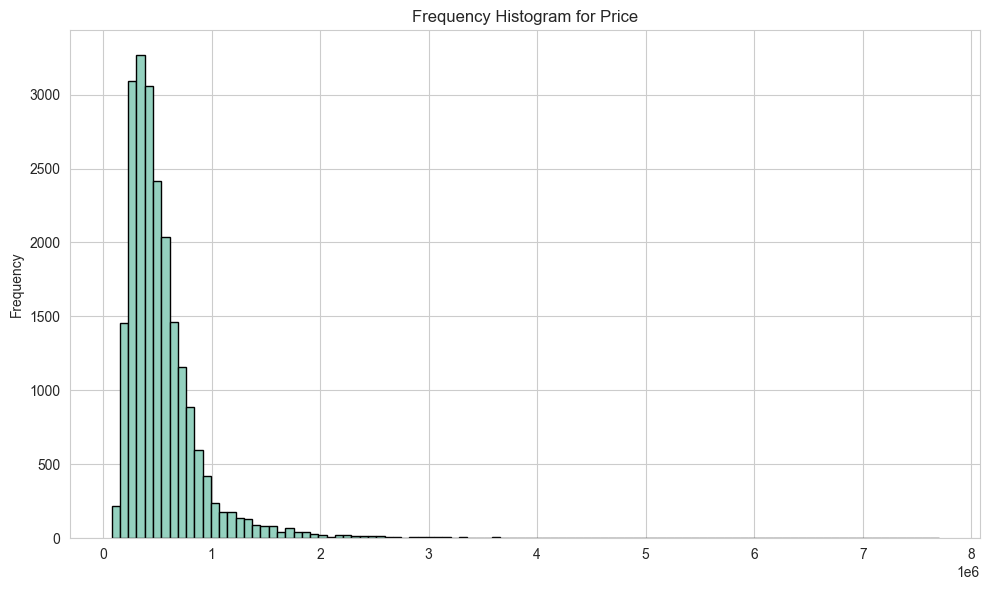

In [22]:
data['price'].plot.hist(bins=100, edgecolor='black', figsize=(10, 6))
plt.title("Frequency Histogram for Price")
plt.tight_layout()

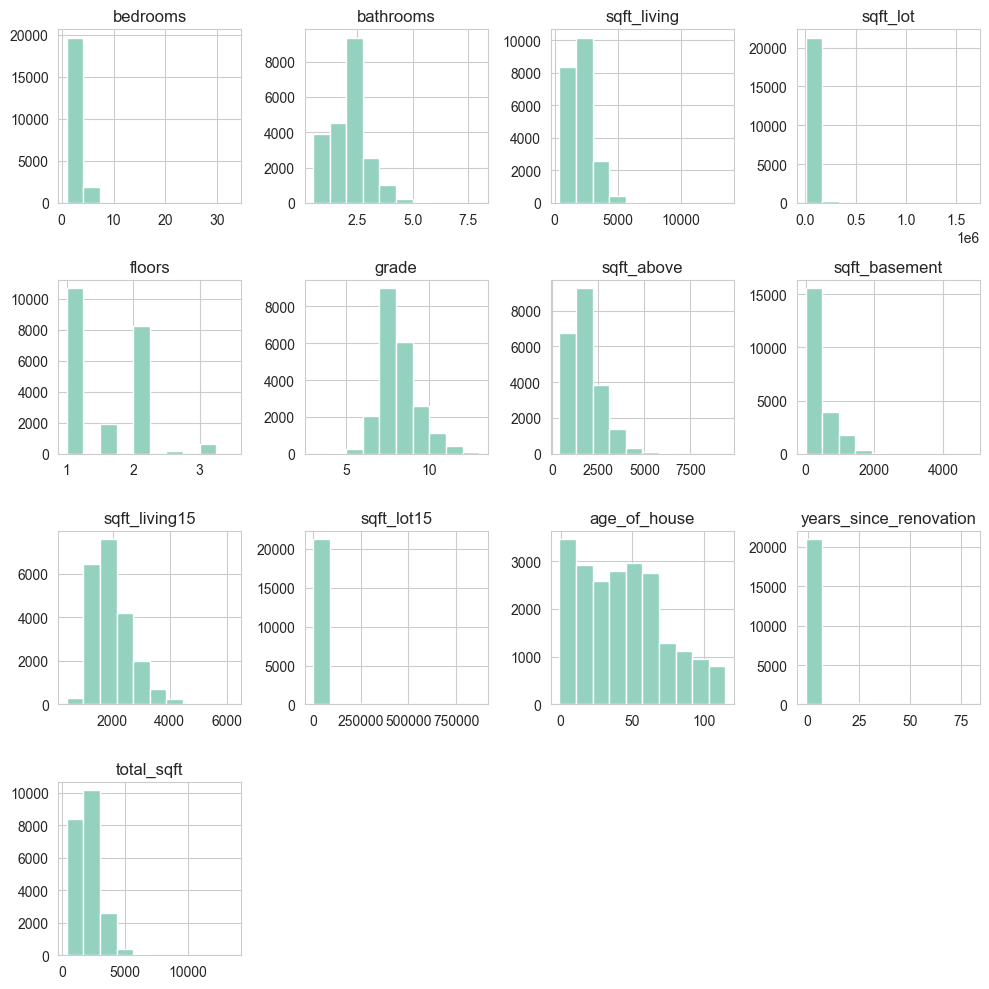

In [23]:
data_num[['bedrooms', 'bathrooms', 'sqft_living','sqft_lot','floors','grade','sqft_above','sqft_basement','sqft_living15','sqft_lot15','age_of_house','years_since_renovation','total_sqft']].hist(figsize=(10,10))
plt.tight_layout()

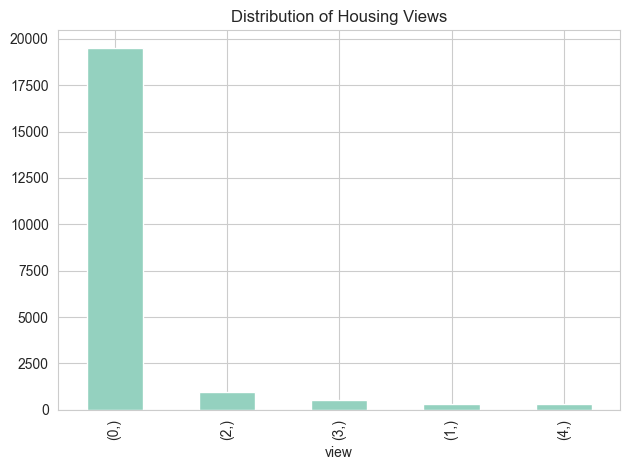

In [24]:
data_cat[["view"]].value_counts().plot(kind='bar')
plt.title("Distribution of Housing Views")
plt.tight_layout()

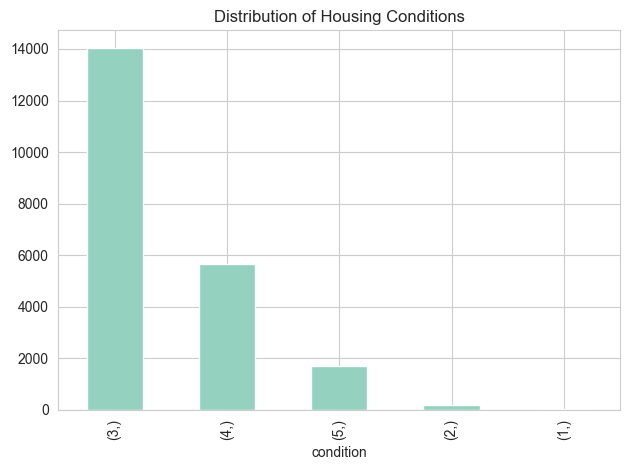

In [25]:
data_cat[["condition"]].value_counts().plot(kind='bar')
plt.title("Distribution of Housing Conditions")
plt.tight_layout()

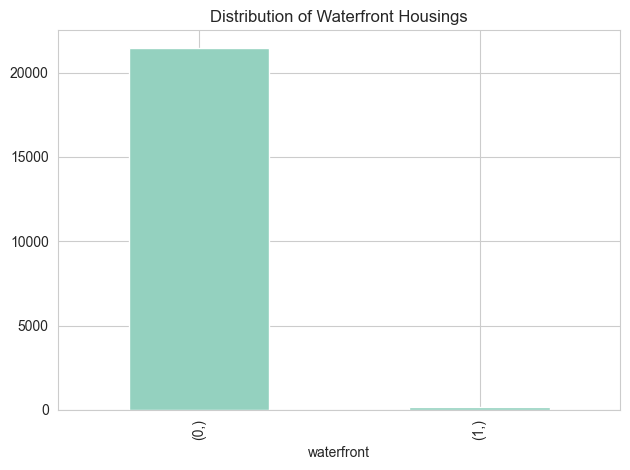

In [26]:
data_cat[["waterfront"]].value_counts().plot(kind='bar')
plt.title("Distribution of Waterfront Housings")
plt.tight_layout()

# Data Sample Correlation

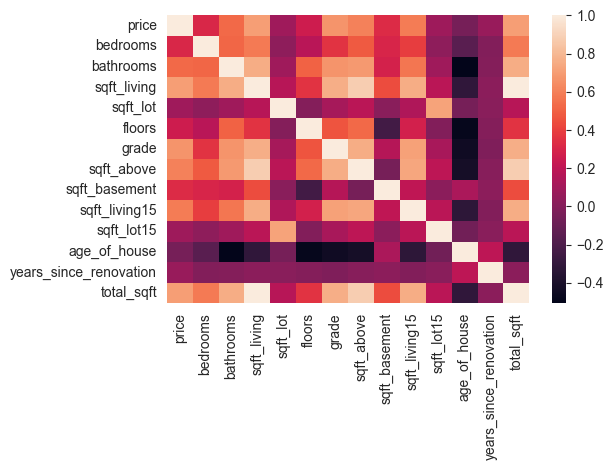

In [27]:
sns.heatmap(data_num.corr())
plt.tight_layout()

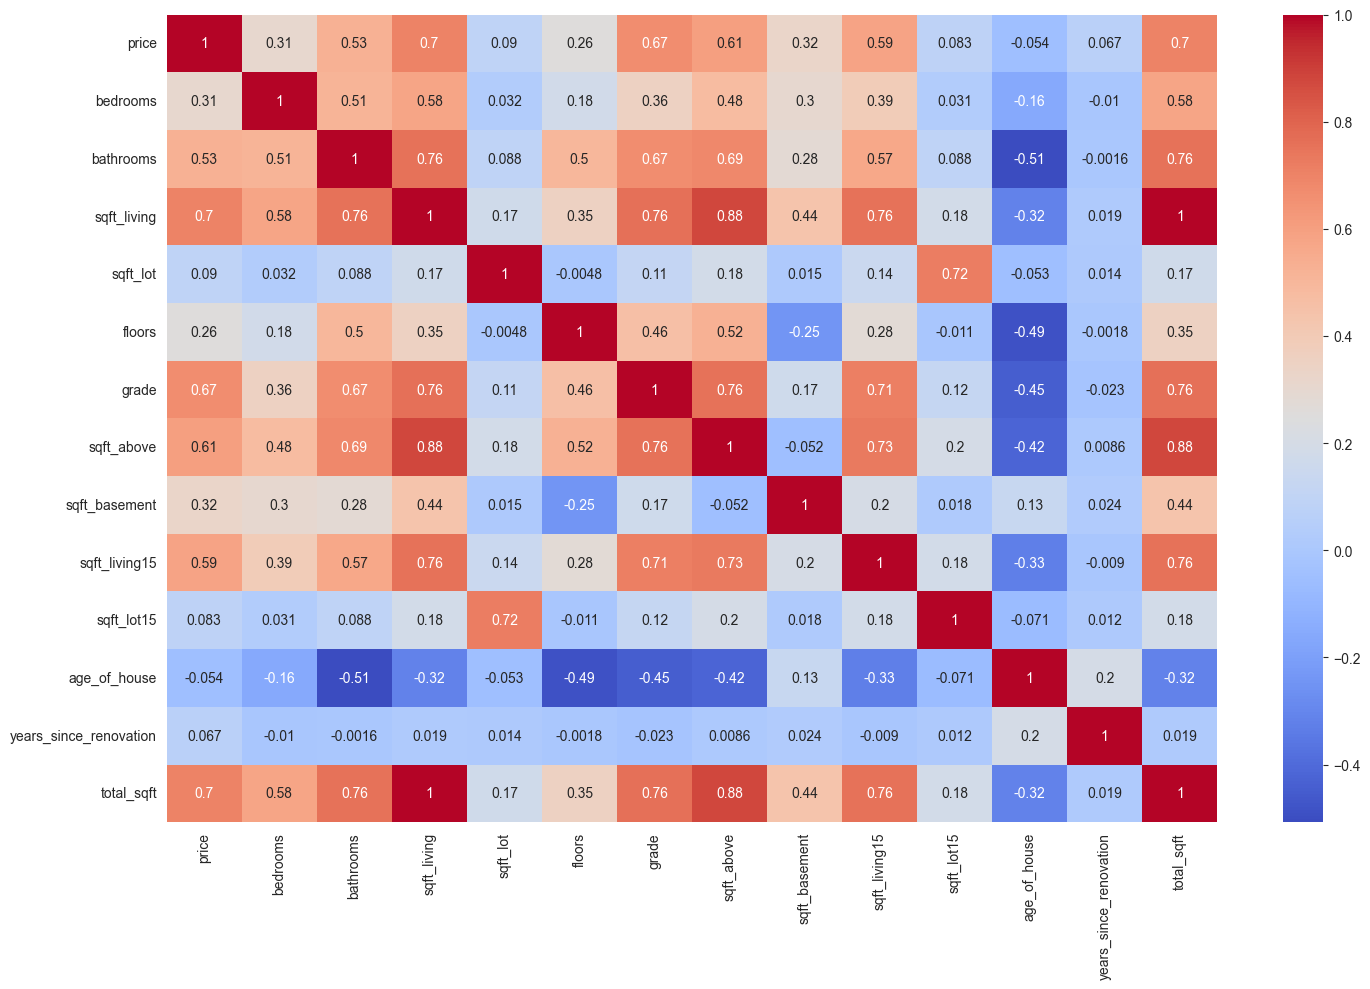

In [28]:
CM = data_num.corr()
plt.figure(figsize=(15,10))
sns.heatmap(CM, annot=True, cmap='coolwarm')
plt.tight_layout()

In [29]:
correlation_matrix = data.corr()
print(correlation_matrix['price'].sort_values(ascending=False))

price                     1.000000
total_sqft                0.701917
sqft_living               0.701917
grade                     0.667951
sqft_above                0.605368
sqft_living15             0.585241
bathrooms                 0.525906
view                      0.397370
sqft_basement             0.323799
bedrooms                  0.308787
waterfront                0.266398
floors                    0.256804
sqft_lot                  0.089876
sqft_lot15                0.082845
years_since_renovation    0.067155
condition                 0.036056
sales_year                0.003727
age_of_house             -0.053890
Name: price, dtype: float64


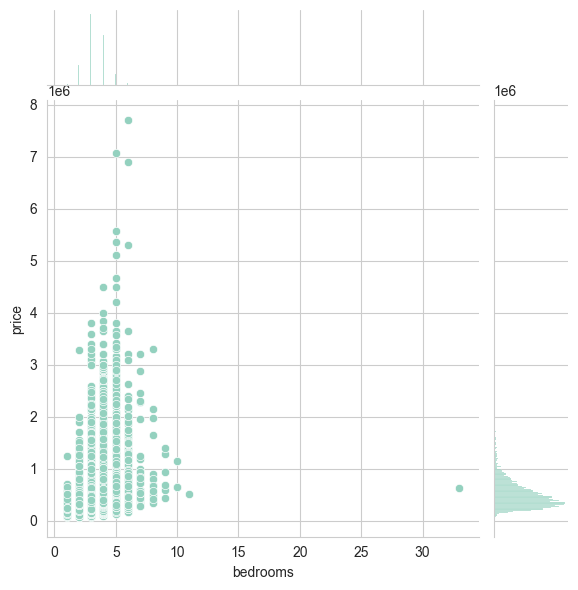

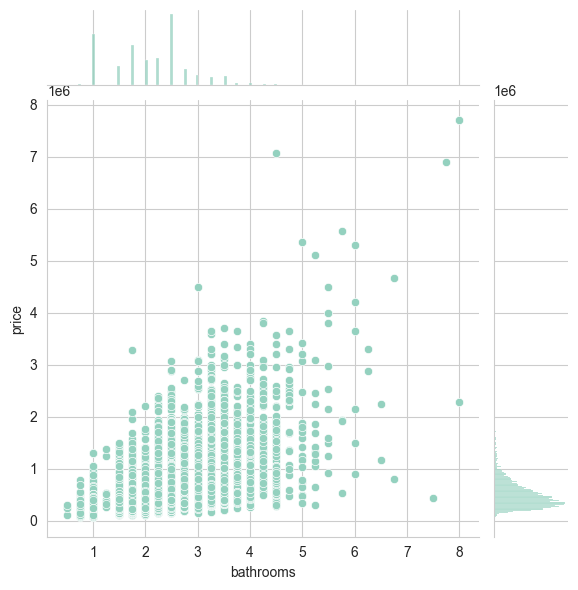

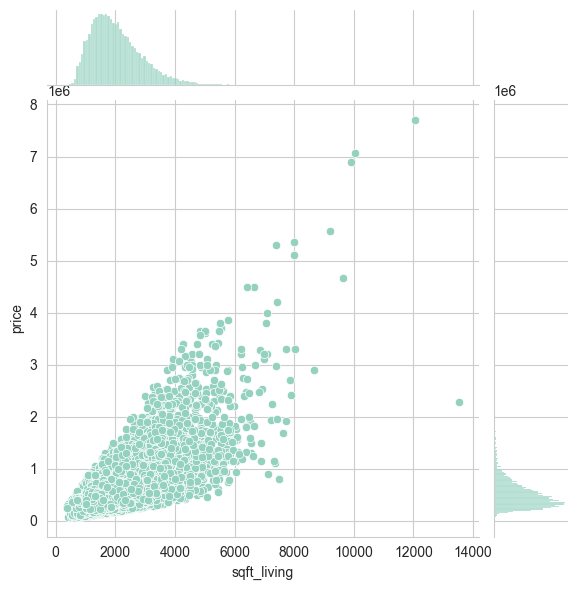

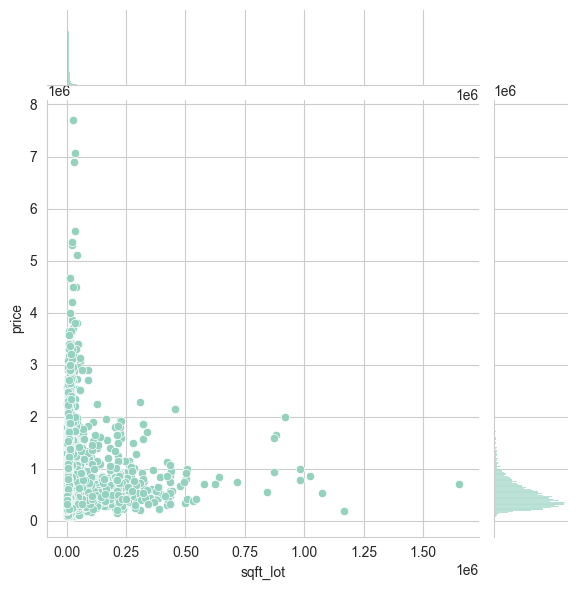

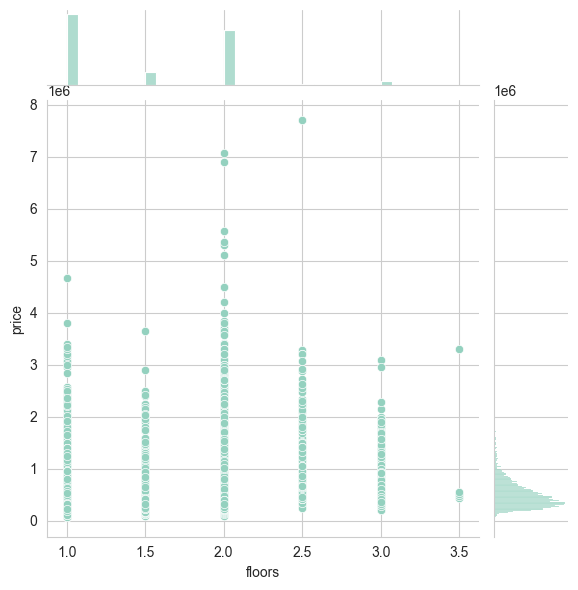

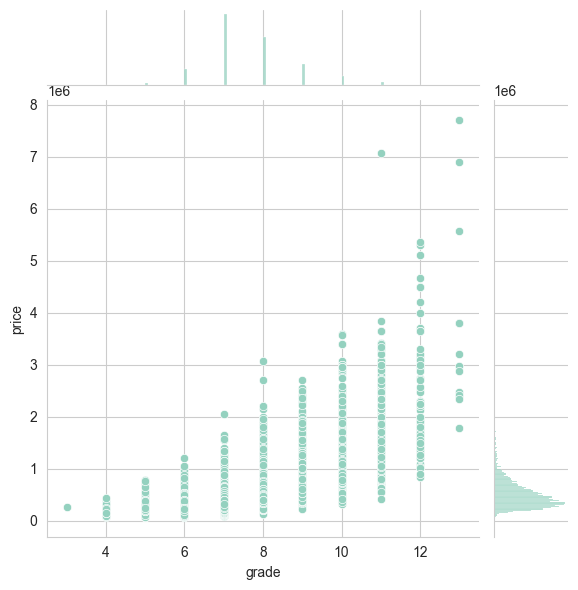

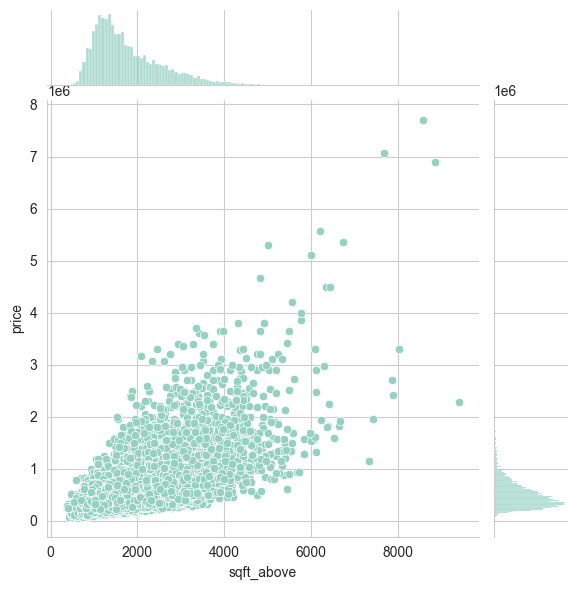

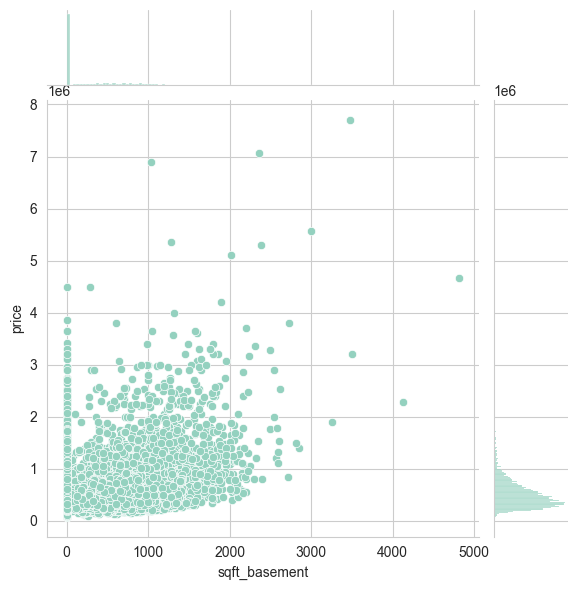

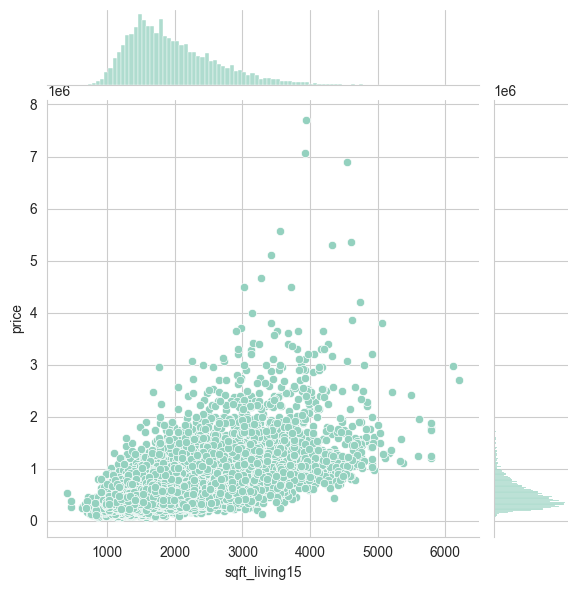

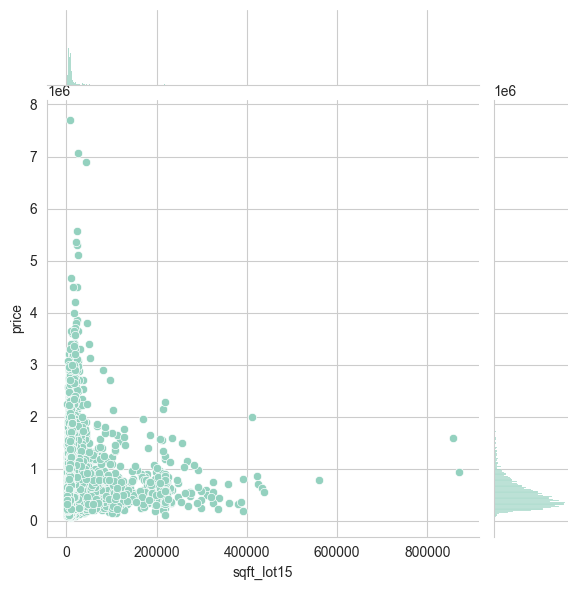

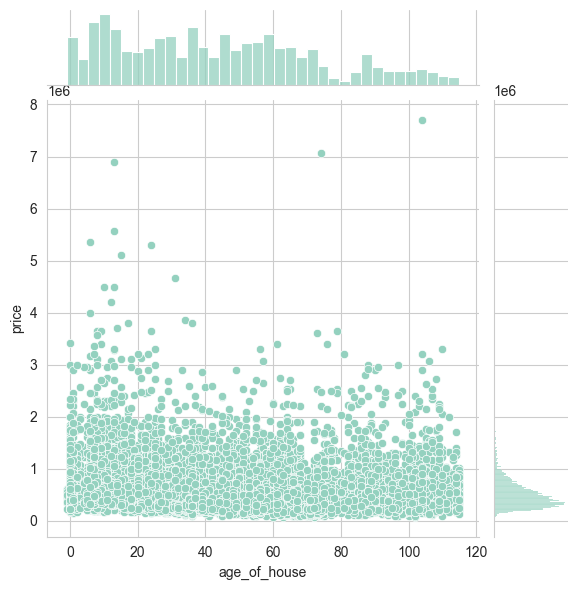

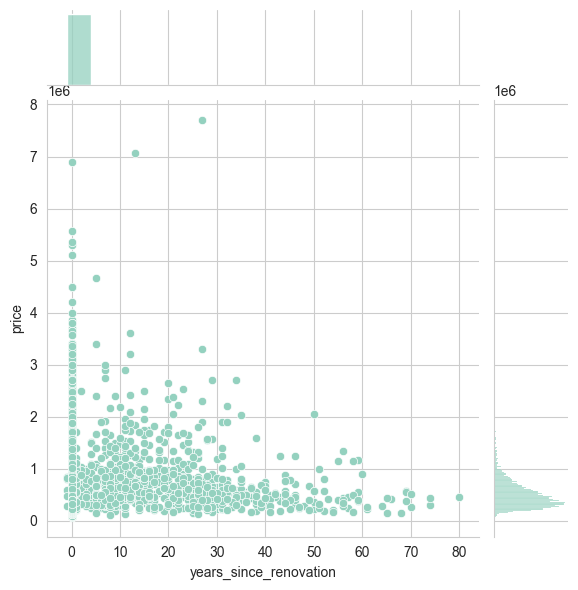

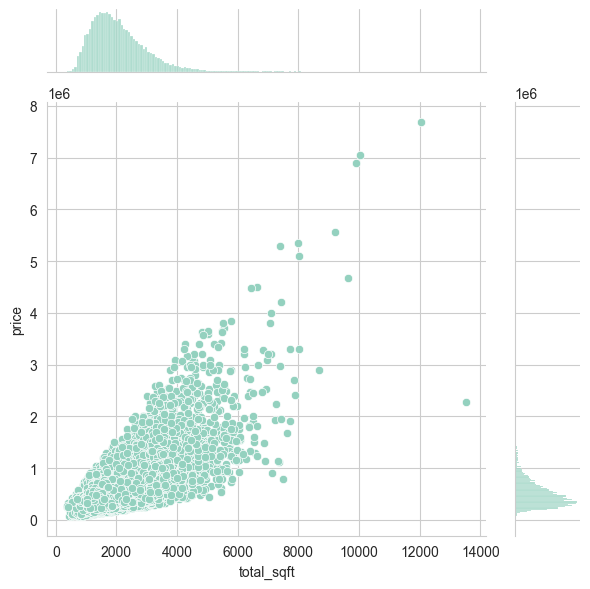

In [30]:
continuous_vars = ['bedrooms', 'bathrooms', 'sqft_living','sqft_lot','floors','grade','sqft_above','sqft_basement','sqft_living15','sqft_lot15','age_of_house','years_since_renovation','total_sqft']
for var in continuous_vars:
    sns.jointplot(x=var, y='price', data=data)
    
plt.tight_layout()

# Dummy Variables

In [31]:
data = pd.get_dummies(data, columns=cat, drop_first=False)

In [32]:
data.head()

,sales_year,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,...,view_2,view_3,view_4,condition_1,condition_2,condition_3,condition_4,condition_5,waterfront_0,waterfront_1
0,2014,221900.0,3,1.00,1180,5650,1.0,7,1180,0,...,False,False,False,False,False,True,False,False,True,False
1,2014,538000.0,3,2.25,2570,7242,2.0,7,2170,400,...,False,False,False,False,False,True,False,False,True,False
2,2015,180000.0,2,1.00,770,10000,1.0,6,770,0,...,False,False,False,False,False,True,False,False,True,False
3,2014,604000.0,4,3.00,1960,5000,1.0,7,1050,910,...,False,False,False,False,False,False,False,True,True,False
4,2015,510000.0,3,2.00,1680,8080,1.0,8,1680,0,...,False,False,False,False,False,True,False,False,True,False


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   sales_year              21597 non-null  int32  
 1   price                   21597 non-null  float64
 2   bedrooms                21597 non-null  int64  
 3   bathrooms               21597 non-null  float64
 4   sqft_living             21597 non-null  int64  
 5   sqft_lot                21597 non-null  int64  
 6   floors                  21597 non-null  float64
 7   grade                   21597 non-null  int64  
 8   sqft_above              21597 non-null  int64  
 9   sqft_basement           21597 non-null  int64  
 10  sqft_living15           21597 non-null  int64  
 11  sqft_lot15              21597 non-null  int64  
 12  age_of_house            21597 non-null  int64  
 13  years_since_renovation  21597 non-null  int64  
 14  total_sqft              21597 non-null

In [34]:
boolean_columns = data.select_dtypes(include='bool').columns
data[boolean_columns] = data[boolean_columns].astype(int)

# Linear Regression Model

In [35]:
Y = data['price']
X = data.drop(['price'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [36]:
# Printing the coefficients of the model
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [ 2.51812718e+04 -3.72953809e+04  4.73443969e+04  6.37852297e+01
 -9.20152858e-04  2.81087494e+04  1.22144354e+05  3.03887285e+01
  3.33965013e+01  2.45333133e+01 -5.48628120e-01  3.70295585e+03
 -1.29147000e+03  6.37852297e+01 -1.10898916e+05  4.77220624e+03
 -6.28866143e+04 -9.91117200e+03  1.78924496e+05 -1.70554954e+04
 -1.19954759e+04 -1.06550174e+04  6.07108249e+02  3.90988804e+04
 -2.65152464e+05  2.65152464e+05]


In [37]:
# Coefficients of the model with independant variable names
coeffecients = pd.DataFrame(lm.coef_, X.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
sales_year,25181.271762
bedrooms,-37295.380874
bathrooms,47344.396941
sqft_living,63.785230
sqft_lot,-0.000920
floors,28108.749385
grade,122144.354074
sqft_above,30.388728
sqft_basement,33.396501
sqft_living15,24.533313


In [38]:
predictions = lm.predict(X_test)

print(f'R^2 Error: {metrics.r2_score(y_test, predictions)}')
print(f'MAE: {metrics.mean_absolute_error(y_test, predictions)}')
print(f'MSE: {metrics.mean_squared_error(y_test, predictions)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_test, predictions))}')

R^2 Error: 0.6553904240827608
MAE: 138419.0299588839
MSE: 46640309617.822365
RMSE: 215963.67661674583


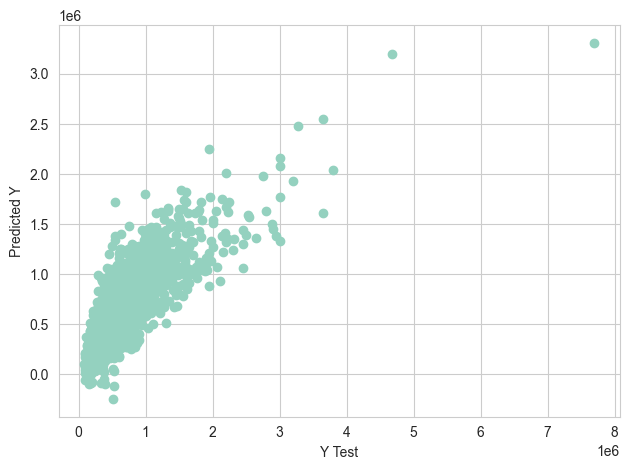

In [39]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.tight_layout()

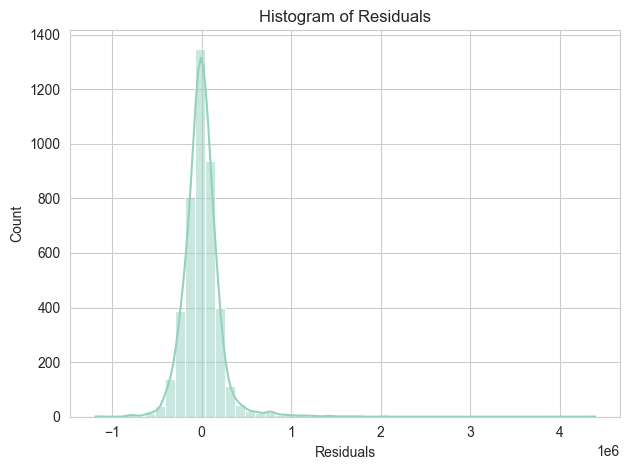

In [40]:
residuals = y_test - predictions
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')
plt.tight_layout()

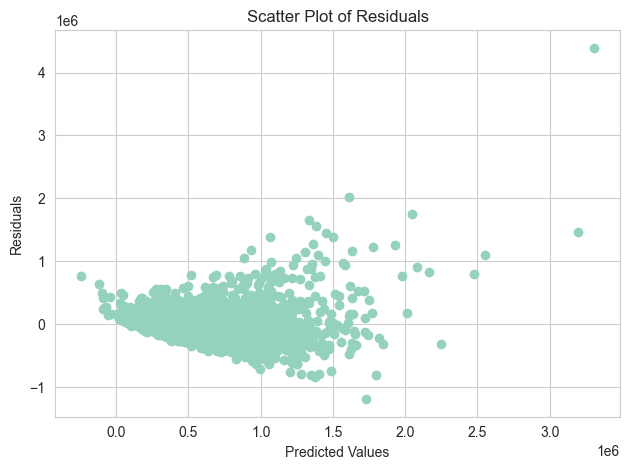

In [41]:
plt.scatter(predictions, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Scatter Plot of Residuals')
plt.tight_layout()

# Outlier Exclusion

<Axes: >

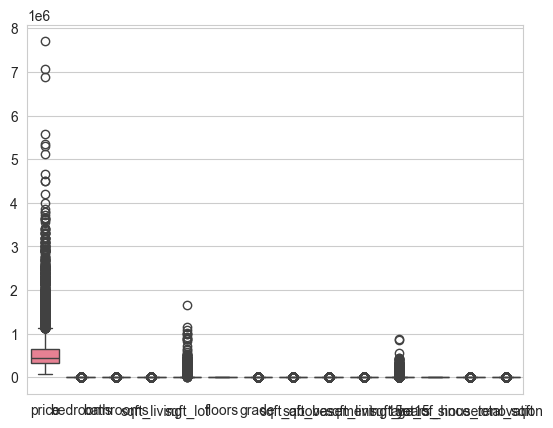

In [42]:
sns.boxplot(data_num)

<Axes: >

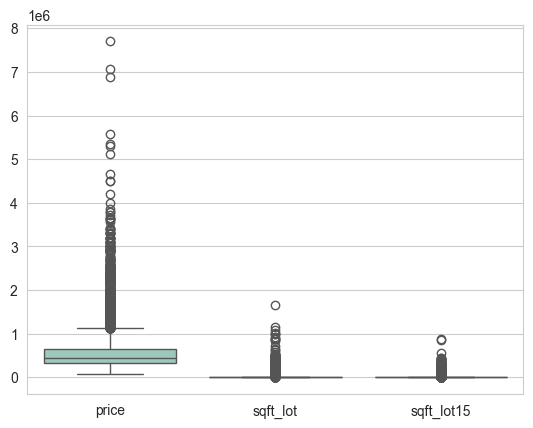

In [43]:
sns.boxplot(data=data[['price','sqft_lot','sqft_lot15']])

In [44]:
q=data_num.quantile(0.90)
q

price                     887000.0
bedrooms                       4.0
bathrooms                      3.0
sqft_living                 3254.0
sqft_lot                   21371.6
floors                         2.0
grade                          9.0
sqft_above                  2950.0
sqft_basement                970.0
sqft_living15               2930.0
sqft_lot15                 17822.0
age_of_house                  89.0
years_since_renovation         0.0
total_sqft                  3254.0
Name: 0.9, dtype: float64

In [45]:
data_cleaned = data
data_cleaned = data_cleaned[data_cleaned['price']<q['price']]
data_cleaned = data_cleaned[data_cleaned['sqft_lot'] < q['sqft_lot']]
data_cleaned = data_cleaned[data_cleaned['sqft_lot15'] < q['sqft_lot15']]

<Axes: >

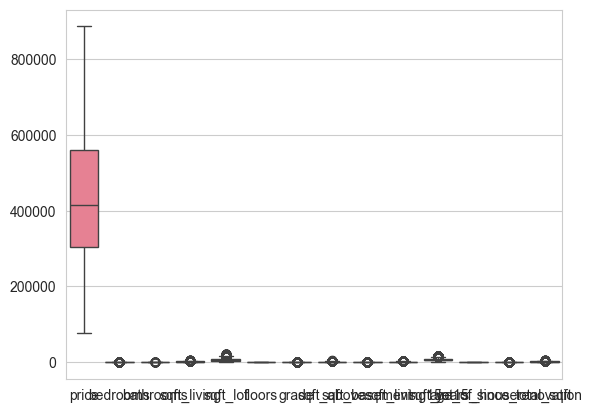

In [46]:
num_col = data_num.columns
sns.boxplot(data_cleaned[num_col])

# Data Standardization

In [47]:
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_cleaned[data_num.columns].values), columns= data_num.columns)

In [48]:
data_scaled = pd.merge(data_scaled, data_cleaned[['view_0','view_1','view_2','view_3','view_4','condition_1','condition_2','condition_3','condition_4','condition_5','waterfront_0','waterfront_1']], left_index = True, right_index = True )

In [49]:
data_scaled

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,sqft_basement,sqft_living15,...,view_2,view_3,view_4,condition_1,condition_2,condition_3,condition_4,condition_5,waterfront_0,waterfront_1
0,-1.259375,-0.319559,-1.45272,-0.996829,-0.438966,-0.853231,-0.437006,-0.663551,-0.657518,-0.893189,...,0,0,0,0,0,1,0,0,1,0
1,0.537241,-0.319559,0.37038,1.040239,0.008327,0.993014,-0.437006,0.875132,0.380986,-0.254545,...,0,0,0,0,0,1,0,0,1,0
2,-1.497522,-1.423742,-1.45272,-1.597690,0.783223,-0.853231,-1.523003,-1.300784,-0.657518,1.624895,...,0,0,0,0,0,1,0,0,1,0
3,0.912364,0.784625,1.46424,0.146274,-0.621592,-0.853231,-0.437006,-0.865601,1.705079,-0.856695,...,0,0,0,0,0,0,0,1,1,0
4,0.378097,-0.319559,0.00576,-0.264071,0.243774,-0.853231,0.648990,0.113561,-0.657518,-0.053828,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17403,-0.474457,-0.319559,0.73500,-0.483898,-1.708638,2.839259,0.648990,-0.119572,-0.657518,-0.546496,...,0,0,0,0,0,1,0,0,1,0
17404,-0.247109,0.784625,0.73500,0.659205,-0.393169,0.993014,0.648990,1.092723,-0.657518,0.000913,...,0,0,0,0,1,0,0,0,1,0
17405,-0.235168,-1.423742,-1.81734,-1.231311,-1.647107,0.993014,-0.437006,-0.912227,-0.657518,-1.477093,...,0,0,0,0,0,1,0,0,1,0
17406,-0.247109,-0.319559,0.73500,-0.381312,-1.355468,0.993014,0.648990,-0.010777,-0.657518,-0.765460,...,0,0,0,0,0,0,0,1,1,0


# Linear Regression Model for Cleaned and Standardized Data

In [50]:
Y_scaled = data_scaled['price']
X_scaled = data_scaled.drop(['price'],axis=1)

X_scaled_train, X_scaled_test, Y_scaled_train, Y_scaled_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, random_state=10)

lm = LinearRegression()
lm.fit(X_scaled_train,Y_scaled_train)

LinearRegression()

In [51]:
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [-5.85643849e-02  8.07329092e-02 -3.41737454e+12 -6.20097135e-02
  7.68495054e-02  4.49687531e-01  7.39432017e+12  4.42653705e+12
  1.95112027e-01 -1.07225761e-01  4.29258279e-01 -1.63859944e-02
 -4.42453157e+12  1.99027077e+10  1.99027077e+10  1.99027077e+10
  1.99027077e+10  1.99027077e+10 -2.54556745e+11 -2.54556745e+11
 -2.54556745e+11 -2.54556745e+11 -2.54556745e+11  2.63805015e+10
  2.63805015e+10]


In [52]:
# Coefficients of the model with independant variable names
coeffecients = pd.DataFrame(lm.coef_, X_scaled.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
bedrooms,-5.856438e-02
bathrooms,8.073291e-02
sqft_living,-3.417375e+12
sqft_lot,-6.200971e-02
floors,7.684951e-02
grade,4.496875e-01
sqft_above,7.394320e+12
sqft_basement,4.426537e+12
sqft_living15,1.951120e-01
sqft_lot15,-1.072258e-01


In [53]:
predictions = lm.predict(X_scaled_test)

print(f'R^2 Error: {metrics.r2_score(Y_scaled_test, predictions)}')
print(f'MAE: {metrics.mean_absolute_error(Y_scaled_test, predictions)}')
print(f'MSE: {metrics.mean_squared_error(Y_scaled_test, predictions)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(Y_scaled_test, predictions))}')

R^2 Error: 0.5091825545733274
MAE: 0.5652154224997066
MSE: 0.5040321288054967
RMSE: 0.7099522017752299


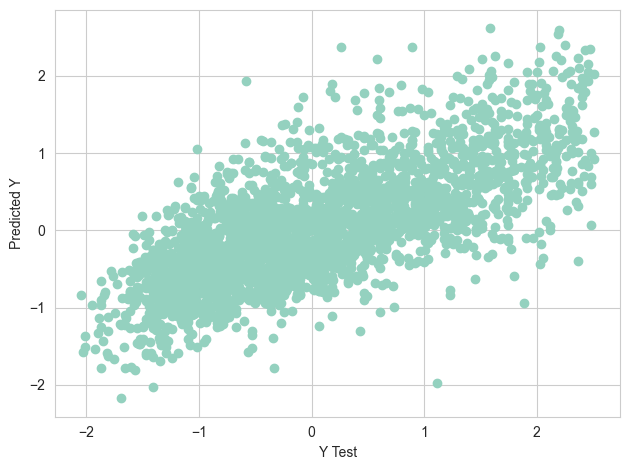

In [54]:
plt.scatter(Y_scaled_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.tight_layout()

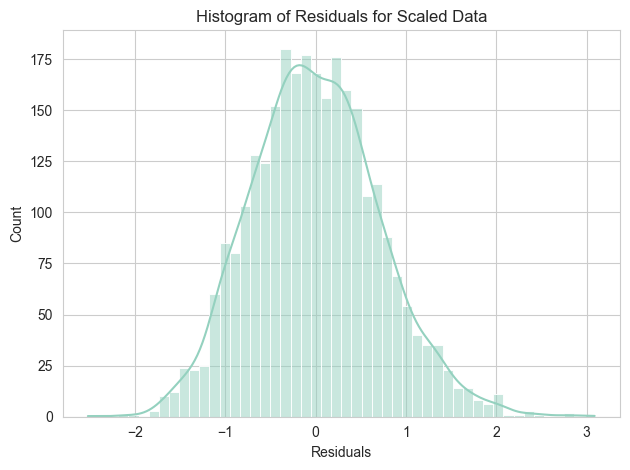

In [55]:
residuals = Y_scaled_test - predictions
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals for Scaled Data')
plt.tight_layout()

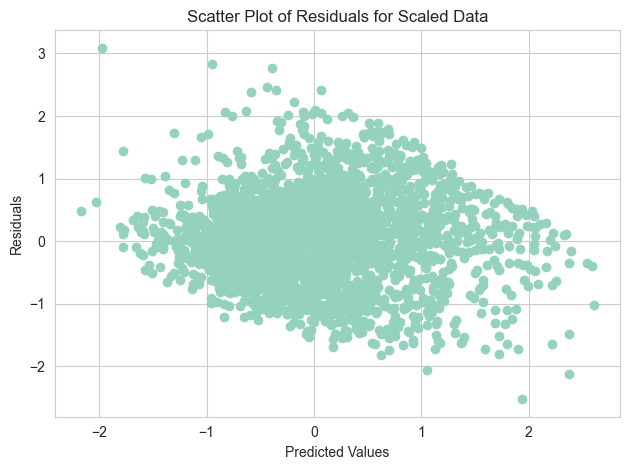

In [56]:
plt.scatter(predictions, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Scatter Plot of Residuals for Scaled Data')
plt.tight_layout()

# Stepwise Elimination of Insignificant Independant Variables using mlxtend

In [64]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Initialize the SequentialFeatureSelector for backward elimination
sfs_backward = SFS(lm,
                   k_features="best",  # You can set this to a specific number if you want a certain number of features
                   forward=False,
                   floating=False,
                   scoring='r2',
                   cv=5)  # 5-fold cross-validation

# Fit the model to the training data
sfs_backward = sfs_backward.fit(X_scaled_train, Y_scaled_train)

# Get the selected feature names
selected_features_backward = list(sfs_backward.k_feature_names_)
print("Selected features by backward elimination:", selected_features_backward)

# Transform the training and test sets to include only the selected features
X_new = X_scaled[selected_features_backward]
X_train_backward = X_scaled_train[selected_features_backward]
X_test_backward = X_scaled_test[selected_features_backward]

# Train the model on the selected features
lm.fit(X_train_backward, Y_scaled_train)
predictions_backward = lm.predict(X_test_backward)

# Evaluate the model
print(f'R^2 Error (Backward Elimination): {metrics.r2_score(Y_scaled_test, predictions_backward)}')
print(f'MAE (Backward Elimination): {metrics.mean_absolute_error(Y_scaled_test, predictions_backward)}')
print(f'MSE (Backward Elimination): {metrics.mean_squared_error(Y_scaled_test, predictions_backward)}')
print(f'RMSE (Backward Elimination): {np.sqrt(metrics.mean_squared_error(Y_scaled_test, predictions_backward))}')

Selected features by backward elimination: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'age_of_house', 'years_since_renovation', 'total_sqft', 'view_1', 'view_4', 'condition_3', 'waterfront_0']
R^2 Error (Backward Elimination): 0.5087140584990568
MAE (Backward Elimination): 0.5650506287323946
MSE (Backward Elimination): 0.5045132385864386
RMSE (Backward Elimination): 0.7102909534736019


In [63]:
# Coefficients of the model with independant variable names
coeffecients = pd.DataFrame(lm.coef_, X_new.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
bedrooms,-5.944813e-02
bathrooms,7.704790e-02
sqft_living,-3.997902e+12
sqft_lot,-6.240586e-02
floors,7.797390e-02
grade,4.496651e-01
sqft_above,6.611724e+12
sqft_basement,3.958044e+12
sqft_living15,1.959097e-01
sqft_lot15,-1.070631e-01


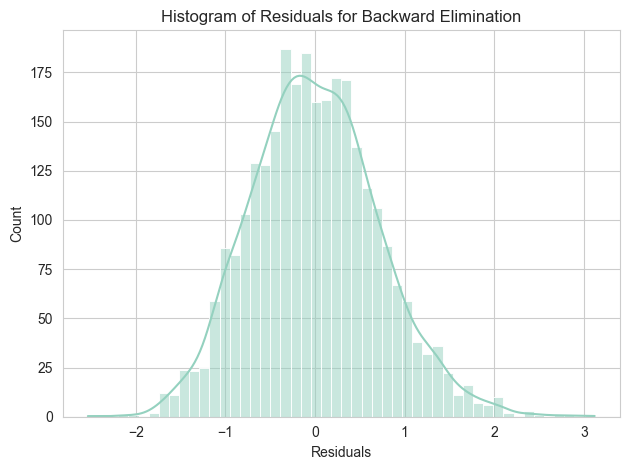

In [59]:
# Residuals for backward elimination
residuals_backward = Y_scaled_test - predictions_backward
sns.histplot(residuals_backward, bins=50, kde=True)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals for Backward Elimination')
plt.tight_layout()

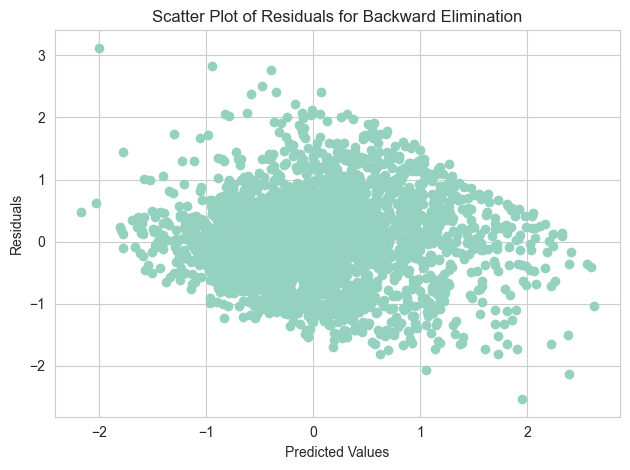

In [60]:
plt.scatter(predictions_backward, residuals_backward)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Scatter Plot of Residuals for Backward Elimination')
plt.tight_layout()

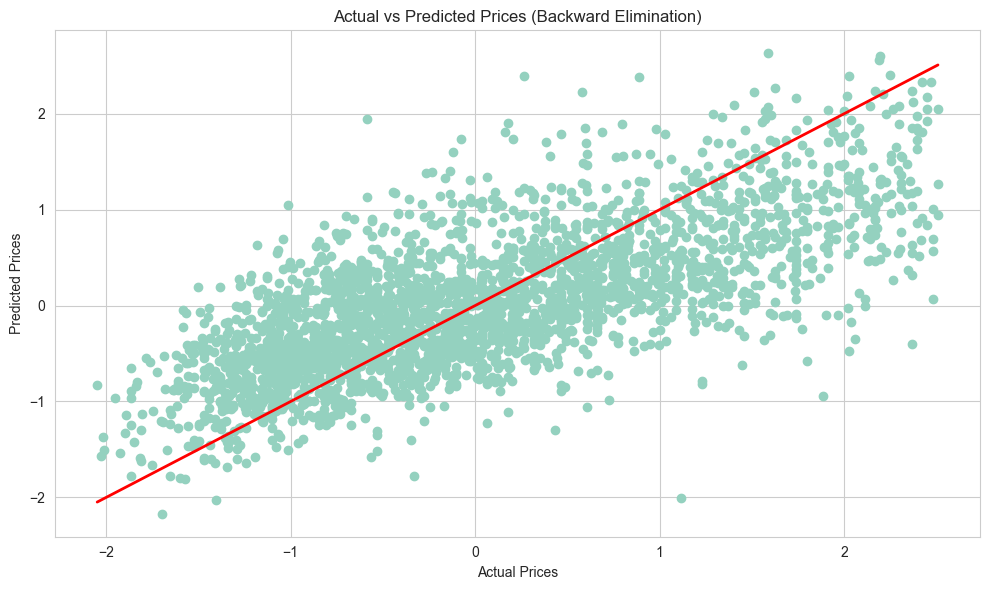

In [61]:
plt.figure(figsize=(10, 6))
plt.scatter(Y_scaled_test, predictions_backward)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (Backward Elimination)')
plt.plot([Y_scaled_test.min(), Y_scaled_test.max()], [Y_scaled_test.min(), Y_scaled_test.max()], color='red', lw=2)  # Adding a line for perfect prediction
plt.tight_layout()
plt.show()